In [2]:
# Install compatible versions together
%pip install --upgrade scikit-learn==1.5.2 imbalanced-learn==0.13.0 kneed pyclustering

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install pandas
%pip install seaborn

# Standard library
import random

# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Scikit-learn - Core utilities
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

# Scikit-learn - Metrics and evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_curve, auc,
    silhouette_samples, silhouette_score
)
from sklearn.inspection import permutation_importance

# Scikit-learn - Algorithms
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.cluster import DBSCAN, KMeans

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import Pipeline as ImbPipeline

%pip install xgboost

# Other ML libraries
from xgboost import XGBClassifier
from kneed import KneeLocator

# Clustering libraries
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import distance_metric, type_metric

# Scipy
from scipy.spatial.distance import cdist

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd

file_path = 'synthetic_fraud_dataset.csv'  # Update this path to your local file location if needed
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("Shape of the dataset:", df.shape)
display(df.head())

Shape of the dataset: (50000, 21)


,Transaction_ID,User_ID,Transaction_Amount,Transaction_Type,Timestamp,Account_Balance,Device_Type,Location,Merchant_Category,IP_Address_Flag,...,Daily_Transaction_Count,Avg_Transaction_Amount_7d,Failed_Transaction_Count_7d,Card_Type,Card_Age,Transaction_Distance,Authentication_Method,Risk_Score,Is_Weekend,Fraud_Label
0,TXN_33553,USER_1834,39.79,POS,2023-08-14 19:30:00,93213.17,Laptop,Sydney,Travel,0,...,7,437.63,3,Amex,65,883.17,Biometric,0.8494,0,0
1,TXN_9427,USER_7875,1.19,Bank Transfer,2023-06-07 04:01:00,75725.25,Mobile,New York,Clothing,0,...,13,478.76,4,Mastercard,186,2203.36,Password,0.0959,0,1
2,TXN_199,USER_2734,28.96,Online,2023-06-20 15:25:00,1588.96,Tablet,Mumbai,Restaurants,0,...,14,50.01,4,Visa,226,1909.29,Biometric,0.8400,0,1
3,TXN_12447,USER_2617,254.32,ATM Withdrawal,2023-12-07 00:31:00,76807.20,Tablet,New York,Clothing,0,...,8,182.48,4,Visa,76,1311.86,OTP,0.7935,0,1
4,TXN_39489,USER_2014,31.28,POS,2023-11-11 23:44:00,92354.66,Mobile,Mumbai,Electronics,0,...,14,328.69,4,Mastercard,140,966.98,Password,0.3819,1,1


In [5]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Transaction_Type'] = df['Transaction_Type'].astype('category')
df['Device_Type'] = df['Device_Type'].astype('category')
df['Location'] = df['Location'].astype('category')
df['Merchant_Category'] = df['Merchant_Category'].astype('category')
df['Card_Type'] = df['Card_Type'].astype('category')
df['Authentication_Method'] = df['Authentication_Method'].astype('category')
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month
df['Year'] = df['Timestamp'].dt.year

In [6]:
exclude_features = ['Transaction_ID', 'User_ID', 'Timestamp', 'Risk_Score',]

categorical_features = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
                        'Card_Type', 'Authentication_Method', 'Hour', 'Month', 'Year']

boolean_features = ['IP_Address_Flag', 'Is_Weekend', 'Previous_Fraudulent_Activity']

numeric_features = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count',
                    'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
                    'Transaction_Distance']
target = 'Fraud_Label'

In [7]:
print("Number of rows and coulmns:",df.shape)
print("\n----- Data Structure -----")
df.info()

Number of rows and coulmns: (50000, 24)

----- Data Structure -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Transaction_ID                50000 non-null  object        
 1   User_ID                       50000 non-null  object        
 2   Transaction_Amount            50000 non-null  float64       
 3   Transaction_Type              50000 non-null  category      
 4   Timestamp                     50000 non-null  datetime64[ns]
 5   Account_Balance               50000 non-null  float64       
 6   Device_Type                   50000 non-null  category      
 7   Location                      50000 non-null  category      
 8   Merchant_Category             50000 non-null  category      
 9   IP_Address_Flag               50000 non-null  int64         
 10  Previous_Fraudulent_Activi

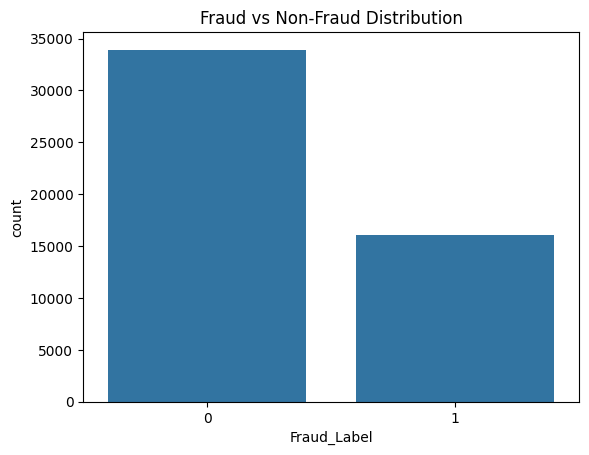

Fraud_Label
0    33933
1    16067
Name: count, dtype: int64

In [8]:
# 9. Visualize class distribution
sns.countplot(x='Fraud_Label', data=df)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()
df['Fraud_Label'].value_counts()

In [9]:
print(df.isnull().sum())

Transaction_ID                  0
User_ID                         0
Transaction_Amount              0
Transaction_Type                0
Timestamp                       0
Account_Balance                 0
Device_Type                     0
Location                        0
Merchant_Category               0
IP_Address_Flag                 0
Previous_Fraudulent_Activity    0
Daily_Transaction_Count         0
Avg_Transaction_Amount_7d       0
Failed_Transaction_Count_7d     0
Card_Type                       0
Card_Age                        0
Transaction_Distance            0
Authentication_Method           0
Risk_Score                      0
Is_Weekend                      0
Fraud_Label                     0
Hour                            0
Month                           0
Year                            0
dtype: int64


In [10]:
df = df.drop(columns=exclude_features)

# Split the data
X = df.drop(columns=[target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

# Create and fit the encoder on training data only
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
one_hot_encoder.fit(X_train[categorical_features])

# Transform both training and test data
X_train_encoded = one_hot_encoder.transform(X_train[categorical_features])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_features])

# Get new column names
new_column_names = one_hot_encoder.get_feature_names_out(categorical_features)

# Create DataFrames with the encoded features
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=new_column_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=new_column_names, index=X_test.index)

# Concatenate with the non-categorical features
X_train_final = pd.concat([X_train.drop(columns=categorical_features), X_train_encoded_df], axis=1)
X_test_final = pd.concat([X_test.drop(columns=categorical_features), X_test_encoded_df], axis=1)

# Scale numerical features
scaler = StandardScaler()
X_train_final[numeric_features] = scaler.fit_transform(X_train_final[numeric_features])
X_test_final[numeric_features] = scaler.transform(X_test_final[numeric_features])

In [11]:
print('Decision Tree Classifier')
m1 = DecisionTreeClassifier(random_state=42)
m1.fit(X_train_final, y_train)
print(classification_report(y_test, m1.predict(X_test_final)))

sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train_final, y_train)
m1.fit(X_train_resampled, y_train_resampled)
print('Decision Tree Classifier with SMOTE')
print(classification_report(y_test, m1.predict(X_test_final)))

nr = NearMiss()
X_train_nr_resampled, y_train_nr_resampled = nr.fit_resample(X_train_final, y_train)
m1.fit(X_train_nr_resampled, y_train_nr_resampled)
print('Decision Tree Classifier with NearMiss')
print(classification_report(y_test, m1.predict(X_test_final)))

Decision Tree Classifier
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      8483
           1       0.66      0.68      0.67      4017

    accuracy                           0.78     12500
   macro avg       0.75      0.76      0.75     12500
weighted avg       0.79      0.78      0.78     12500

Decision Tree Classifier with SMOTE
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      8483
           1       0.65      0.68      0.66      4017

    accuracy                           0.78     12500
   macro avg       0.75      0.75      0.75     12500
weighted avg       0.78      0.78      0.78     12500

Decision Tree Classifier with NearMiss
              precision    recall  f1-score   support

           0       0.85      0.64      0.73      8483
           1       0.50      0.76      0.60      4017

    accuracy                           0.68     12500
   macro avg       0.67     

In [12]:
# Original model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_model.fit(X_train_final, y_train)
print('\n[Original] Random Forest Classifier')
print(classification_report(y_test, rf_model.predict(X_test_final)))

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# Grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='f1',
    n_jobs=-1,
    verbose=2
)

# Fit and predict
grid_search.fit(X_train_final, y_train)
best_rf_model = grid_search.best_estimator_

print('\n[Tuned] Random Forest Classifier (Best Params):')
print(grid_search.best_params_)
print(classification_report(y_test, best_rf_model.predict(X_test_final)))


[Original] Random Forest Classifier
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Fitting 3 folds for each of 12 candidates, totalling 36 fits

[Tuned] Random Forest Classifier (Best Params):
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



In [13]:
# --- Nouvelle approche : Random Forest Calibré avec Sous-échantillonnage (Ratio 0.7) ---

from imblearn.under_sampling import RandomUnderSampler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score
import numpy as np
import pandas as pd

# 1. Sous-échantillonnage avec un ratio de 70%
# On utilise les données déjà prétraitées : X_train_final
rus = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
X_train_rus, y_train_rus = rus.fit_resample(X_train_final, y_train)

print("--- Distribution des classes après sous-échantillonnage (Ratio 0.7) ---")
print(pd.Series(y_train_rus).value_counts())

# 2. Créer et entraîner le modèle Random Forest calibré
# Le modèle de base
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Le wrapper de calibration
rf_calibrated = CalibratedClassifierCV(rf_base, method='sigmoid', cv=3, n_jobs=-1)

# Entraînement sur les données sous-échantillonnées
rf_calibrated.fit(X_train_rus, y_train_rus)

# 3. Prédiction des probabilités sur l'ensemble de test
# On utilise les données de test prétraitées : X_test_final
y_proba = rf_calibrated.predict_proba(X_test_final)[:, 1]

# 4. Trouver le seuil optimal basé sur le F1-score
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
# Calculer F1 pour chaque seuil, en évitant la division par zéro
f1_scores = (2 * precision * recall) / (precision + recall + 1e-9)

# Ignorer le dernier score car il correspond à un seuil non défini
optimal_idx = np.argmax(f1_scores[:-1])
optimal_threshold = thresholds[optimal_idx]
print(f"\nSeuil optimal trouvé : {optimal_threshold:.4f}")

# 5. Évaluation avec les deux seuils

# Évaluation avec le seuil par défaut (0.5)
y_pred_default = (y_proba >= 0.5).astype(int)
print("\n--- Performance avec Seuil par Défaut (0.5) ---")
print(classification_report(y_test, y_pred_default))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_default))
    
# Évaluation avec le seuil optimal
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)
print(f"\n--- Performance avec Seuil Optimal ({optimal_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_optimal))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_optimal))

--- Distribution des classes après sous-échantillonnage (Ratio 0.7) ---
Fraud_Label
0    17214
1    12050
Name: count, dtype: int64

Seuil optimal trouvé : 0.9639

--- Performance avec Seuil par Défaut (0.5) ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Matrice de confusion :
[[8482    1]
 [1539 2478]]

--- Performance avec Seuil Optimal (0.9639) ---
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500

Matrice de confusion :
[[8483    0]

--- Analyse pour un Seuil Optimisé (Précision >= 0.8) ---
Nouveau seuil optimal trouvé : 0.2978
À ce seuil, Précision = 0.80, Rappel = 0.65

--- Performance avec le nouveau seuil optimal (0.2978) ---
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      8483
           1       0.80      0.65      0.72      4017

    accuracy                           0.84     12500
   macro avg       0.82      0.79      0.80     12500
weighted avg       0.83      0.84      0.83     12500

Matrice de confusion :
[[7832  651]
 [1411 2606]]


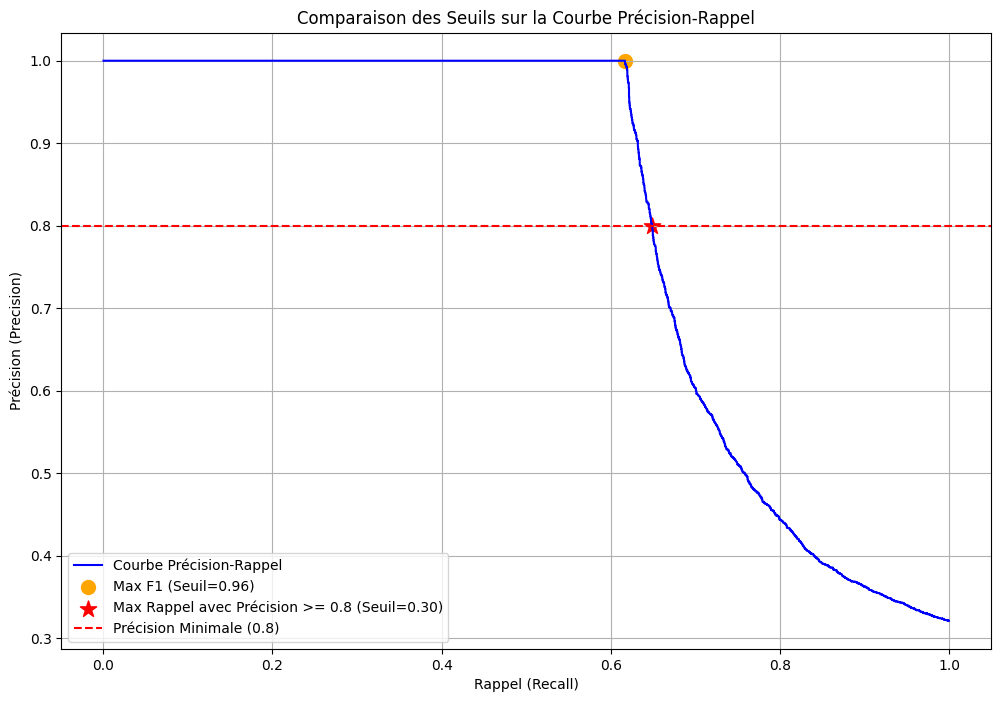

In [14]:
# --- Recherche d'un Seuil Optimisé pour un Rappel Élevé ---

# On suppose que les variables `y_proba`, `y_test`, `precision`, `recall`, 
# et `thresholds` sont déjà calculées dans la cellule précédente.

# 1. Définir la contrainte de précision minimale
# Vous pouvez ajuster cette valeur. Par exemple, 0.85 signifie qu'on accepte
# que 15% des alertes soient des faux positifs au maximum.
MIN_PRECISION = 0.80

# 2. Trouver le meilleur seuil sous cette contrainte
# On ignore le dernier élément de `precision` et `recall` car `thresholds` a une taille n-1
valid_indices = np.where(precision[:-1] >= MIN_PRECISION)[0]

# Parmi ces indices valides, trouver celui qui maximise le rappel
best_idx_for_recall = valid_indices[np.argmax(recall[valid_indices])]

# Obtenir le seuil et les performances correspondantes
new_optimal_threshold = thresholds[best_idx_for_recall]
recall_at_threshold = recall[best_idx_for_recall]
precision_at_threshold = precision[best_idx_for_recall]

print(f"--- Analyse pour un Seuil Optimisé (Précision >= {MIN_PRECISION}) ---")
print(f"Nouveau seuil optimal trouvé : {new_optimal_threshold:.4f}")
print(f"À ce seuil, Précision = {precision_at_threshold:.2f}, Rappel = {recall_at_threshold:.2f}")

    # 3. Appliquer le nouveau seuil pour obtenir les prédictions
y_pred_new_optimal = (y_proba >= new_optimal_threshold).astype(int)

# 4. Afficher le rapport de classification et la matrice de confusion
print(f"\n--- Performance avec le nouveau seuil optimal ({new_optimal_threshold:.4f}) ---")
print(classification_report(y_test, y_pred_new_optimal))
print("Matrice de confusion :")
print(confusion_matrix(y_test, y_pred_new_optimal))

# 5. Visualisation pour comparer les points de fonctionnement

# Ancien seuil optimal (basé sur F1-score)
f1_optimal_idx = np.argmax(f1_scores[:-1])
f1_optimal_threshold = thresholds[f1_optimal_idx]
f1_recall = recall[f1_optimal_idx]
f1_precision = precision[f1_optimal_idx]

plt.figure(figsize=(12, 8))
plt.plot(recall[:-1], precision[:-1], 'b-', label='Courbe Précision-Rappel')
plt.xlabel('Rappel (Recall)')
plt.ylabel('Précision (Precision)')
plt.title('Comparaison des Seuils sur la Courbe Précision-Rappel')

# Marquer le point optimisé pour F1
plt.scatter(f1_recall, f1_precision, marker='o', color='orange', s=100, label=f'Max F1 (Seuil={f1_optimal_threshold:.2f})')
# Marquer le nouveau point optimisé pour le rappel
plt.scatter(recall_at_threshold, precision_at_threshold, marker='*', color='red', s=150, label=f'Max Rappel avec Précision >= {MIN_PRECISION} (Seuil={new_optimal_threshold:.2f})')

plt.axhline(y=MIN_PRECISION, color='r', linestyle='--', label=f'Précision Minimale ({MIN_PRECISION})')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [15]:
# --- Test en Conditions Réelles : Évaluation d'une Nouvelle Transaction (Corrigé) ---

import joblib
import pandas as pd
import numpy as np

# 1. Exporter les objets nécessaires
# Le modèle est `rf_calibrated`
# Les `scaler` et `one_hot_encoder` ont été créés dans les premières cellules
# `X_train_final.columns` nous donne l'ordre final des caractéristiques

print("Exportation des fichiers nécessaires...")
joblib.dump(rf_calibrated, 'fraud_model_calibrated.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(one_hot_encoder, 'encoder.pkl')
joblib.dump(X_train_final.columns.tolist(), 'feature_order.pkl')
print("Modèle et transformateurs exportés.")

# 2. Charger les objets pour le test
loaded_model = joblib.load('fraud_model_calibrated.pkl')
loaded_scaler = joblib.load('scaler.pkl')
loaded_encoder = joblib.load('encoder.pkl')
loaded_feature_order = joblib.load('feature_order.pkl')
print("Modèle et transformateurs chargés.")

# 3. Simuler une nouvelle transaction
# Legit transaction example
# new_transaction_data = {
#     'Transaction_Amount': 45.00,                     # Small, normal purchase
#     'Transaction_Type': 'Credit',                    # Money coming into the account
#     'Account_Balance': 1200.00,                       # Normal balance
#     'Device_Type': 'Mobile',                          # Usual device for the user
#     'Location': 'Paris',                              # Usual location
#     'Merchant_Category': 'Groceries',                 # Common spending category
#     'IP_Address_Flag': 0,                             # Clean IP
#     'Previous_Fraudulent_Activity': 0,                # No history of fraud
#     'Daily_Transaction_Count': 2,                     # Normal daily activity
#     'Avg_Transaction_Amount_7d': 40.00,               # Similar to usual amounts
#     'Failed_Transaction_Count_7d': 0,                 # No failed transactions
#     'Card_Type': 'MasterCard',                        # Usual card
#     'Card_Age': 24,                                   # Card held for 2 years
#     'Transaction_Distance': 2,                        # Local transaction
#     'Authentication_Method': 'PIN',                   # Secure authentication
#     'Is_Weekend': 0,                                  # Weekday
#     'Hour': 17,                                       # Afternoon shopping
#     'Month': 8,
#     'Year': 2025
# }
# Fraud transaction example

# new_transaction_data = {
#     'Transaction_Amount': 5000.00,                  # Unusually high for the account
#     'Transaction_Type': 'Debit',                    # Money going out
#     'Account_Balance': 5200.00,                      # Nearly full balance being drained
#     'Device_Type': 'Web',                            # Not the usual device
#     'Location': 'Nigeria',                           # Different country than normal
#     'Merchant_Category': 'Electronics',              # High resale value items
#     'IP_Address_Flag': 1,                            # IP flagged as suspicious
#     'Previous_Fraudulent_Activity': 1,               # Has previous fraud history
#     'Daily_Transaction_Count': 7,                    # Many transactions in one day
#     'Avg_Transaction_Amount_7d': 150.00,              # Normally small transactions
#     'Failed_Transaction_Count_7d': 4,                # Multiple recent failed attempts
#     'Card_Type': 'Visa',                              # Commonly targeted
#     'Card_Age': 0.5,                                  # New card (half a month)
#     'Transaction_Distance': 5000,                     # Very far from normal location
#     'Authentication_Method': 'None',                  # No 2FA or PIN used
#     'Is_Weekend': 1,                                  # Weekend transaction
#     'Hour': 3,                                        # Middle of the night
#     'Month': 8,
#     'Year': 2025
# }
new_transaction_data ={
  "Transaction_Amount": 2100.0,
  "Transaction_Type": "Debit",
  "Account_Balance": 9000.0,
  "Device_Type": "Web",
  "Location": "Tokyo",
  "Merchant_Category": "Electronics",
  "IP_Address_Flag": 0,
  "Previous_Fraudulent_Activity": 0,
  "Daily_Transaction_Count": 1,
  "Avg_Transaction_Amount_7d": 1800.0,
  "Failed_Transaction_Count_7d": 2,
  "Card_Type": "MasterCard",
  "Card_Age": 60,
  "Transaction_Distance": 9800,
  "Authentication_Method": "OTP",
  "Is_Weekend": 1,
  "Hour": 11,
  "Month": 8,
  "Year": 2025
}

new_transaction = pd.DataFrame([new_transaction_data])

# 4. Prétraiter la nouvelle transaction en utilisant les objets chargés
# Définir les listes de caractéristiques
categorical_features = ['Transaction_Type', 'Device_Type', 'Location', 'Merchant_Category',
                        'Card_Type', 'Authentication_Method', 'Hour', 'Month', 'Year']
numeric_features = ['Transaction_Amount', 'Account_Balance', 'Daily_Transaction_Count',
                    'Avg_Transaction_Amount_7d', 'Failed_Transaction_Count_7d', 'Card_Age',
                    'Transaction_Distance']
boolean_features = ['IP_Address_Flag', 'Is_Weekend', 'Previous_Fraudulent_Activity']

# Appliquer l'encodage et la mise à l'échelle
encoded_cats = loaded_encoder.transform(new_transaction[categorical_features])
scaled_nums = loaded_scaler.transform(new_transaction[numeric_features])

# Reconstruire le DataFrame
encoded_df = pd.DataFrame(encoded_cats, columns=loaded_encoder.get_feature_names_out(categorical_features))
scaled_df = pd.DataFrame(scaled_nums, columns=numeric_features)
booleans_df = new_transaction[boolean_features].reset_index(drop=True)

# Concaténer et réorganiser les colonnes pour correspondre à l'entraînement
processed_transaction = pd.concat([scaled_df, booleans_df, encoded_df], axis=1)
processed_transaction = processed_transaction.reindex(columns=loaded_feature_order, fill_value=0)

# 5. Faire la prédiction
prediction_proba = loaded_model.predict_proba(processed_transaction)[0]
fraud_probability = prediction_proba[1]

# Utiliser le seuil optimal trouvé précédemment
final_prediction = 1 if fraud_probability >= new_optimal_threshold else 0

# 6. Afficher le rapport
print("\n--- Analyse de la Nouvelle Transaction ---")
print(f"Probabilité de fraude : {fraud_probability:.2%}")
print(f"Seuil de décision : {new_optimal_threshold:.2%}")
print(f"Prediction : {final_prediction}")


Exportation des fichiers nécessaires...
Modèle et transformateurs exportés.
Modèle et transformateurs chargés.

--- Analyse de la Nouvelle Transaction ---
Probabilité de fraude : 52.55%
Seuil de décision : 29.78%
Prediction : 1


2.4 Model 3: XGBoost Classifier

In [16]:
# Original model
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss')
xgb_model.fit(X_train_final, y_train)

print('\n[Original] XGBoost Classifier')
print(classification_report(y_test, xgb_model.predict(X_test_final)))

# Parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.3],
    'subsample': [0.8, 1.0]
}

# Grid search
grid_search = GridSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit and compare
grid_search.fit(X_train_final, y_train)
best_xgb_model = grid_search.best_estimator_

print('\n[Tuned] XGBoost Classifier (Best Params):')
print(grid_search.best_params_)
print(classification_report(y_test, best_xgb_model.predict(X_test_final)))


[Original] XGBoost Classifier
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      8483
           1       0.98      0.62      0.76      4017

    accuracy                           0.87     12500
   macro avg       0.91      0.81      0.84     12500
weighted avg       0.89      0.87      0.86     12500

Fitting 3 folds for each of 16 candidates, totalling 48 fits

[Tuned] XGBoost Classifier (Best Params):
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500



--- Étape 1: Entraînement du modèle XGBoost ---
Fitting 3 folds for each of 16 candidates, totalling 48 fits

Meilleurs paramètres pour XGBoost :
{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'subsample': 1.0}

Performance de XGBoost avec seuil par défaut (0.5) :
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      8483
           1       1.00      0.62      0.76      4017

    accuracy                           0.88     12500
   macro avg       0.92      0.81      0.84     12500
weighted avg       0.90      0.88      0.87     12500


--- Étape 2: Recherche du seuil optimal pour XGBoost ---

Seuil optimal trouvé (pour Précision >= 0.82): 0.2001

--- Performance avec le nouveau seuil optimal (0.2001) ---
              precision    recall  f1-score   support

           0       0.85      0.93      0.89      8483
           1       0.82      0.65      0.72      4017

    accuracy                           0.84     12500
   m

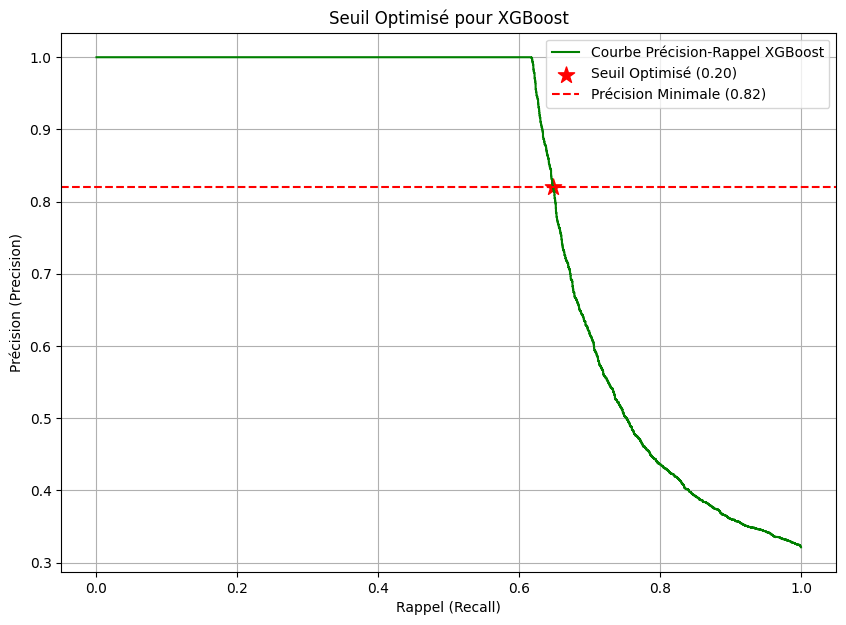

In [17]:
# --- Entraînement et Optimisation Complète de XGBoost ---

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

# --- Partie 1: Entraînement du modèle XGBoost ---

print("--- Étape 1: Entraînement du modèle XGBoost ---")
# Grille de paramètres pour la recherche
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [6, 10], # Profondeurs légèrement plus élevées peuvent être bénéfiques
    'learning_rate': [0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Recherche par grille avec validation croisée
grid_search_xgb = GridSearchCV(
    XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss'),
    param_grid_xgb,
    scoring='f1',
    cv=3,
    verbose=1, # Réduit à 1 pour moins de logs
    n_jobs=-1
)

# Entraînement et sélection du meilleur modèle
grid_search_xgb.fit(X_train_final, y_train)
best_xgb_model = grid_search_xgb.best_estimator_

print('\nMeilleurs paramètres pour XGBoost :')
print(grid_search_xgb.best_params_)
print("\nPerformance de XGBoost avec seuil par défaut (0.5) :")
print(classification_report(y_test, best_xgb_model.predict(X_test_final)))


# --- Partie 2: Recherche d'un Seuil Optimisé (Focus sur le Rappel) ---

print("\n--- Étape 2: Recherche du seuil optimal pour XGBoost ---")

# Prédire les probabilités sur l'ensemble de test
y_proba_xgb = best_xgb_model.predict_proba(X_test_final)[:, 1]

# Calculer la courbe Précision-Rappel
precisions_xgb, recalls_xgb, thresholds_xgb = precision_recall_curve(y_test, y_proba_xgb)

# Définir la contrainte de précision minimale
MIN_PRECISION_XGB = 0.82

# Trouver le meilleur seuil qui respecte la contrainte
valid_indices_xgb = np.where(precisions_xgb[:-1] >= MIN_PRECISION_XGB)[0]

if len(valid_indices_xgb) > 0:
    # Parmi les seuils valides, trouver celui qui maximise le rappel
    best_idx_xgb = valid_indices_xgb[np.argmax(recalls_xgb[valid_indices_xgb])]
    new_optimal_threshold_xgb = thresholds_xgb[best_idx_xgb]

    print(f"\nSeuil optimal trouvé (pour Précision >= {MIN_PRECISION_XGB}): {new_optimal_threshold_xgb:.4f}")

    # Appliquer le nouveau seuil
    y_pred_new_optimal_xgb = (y_proba_xgb >= new_optimal_threshold_xgb).astype(int)

    # Afficher le rapport de classification final
    print(f"\n--- Performance avec le nouveau seuil optimal ({new_optimal_threshold_xgb:.4f}) ---")
    print(classification_report(y_test, y_pred_new_optimal_xgb))
    
    # Visualisation
    plt.figure(figsize=(10, 7))
    plt.plot(recalls_xgb[:-1], precisions_xgb[:-1], 'g-', label='Courbe Précision-Rappel XGBoost')
    plt.xlabel('Rappel (Recall)')
    plt.ylabel('Précision (Precision)')
    plt.title('Seuil Optimisé pour XGBoost')
    plt.scatter(recalls_xgb[best_idx_xgb], precisions_xgb[best_idx_xgb], marker='*', color='red', s=150, label=f'Seuil Optimisé ({new_optimal_threshold_xgb:.2f})')
    plt.axhline(y=MIN_PRECISION_XGB, color='r', linestyle='--', label=f'Précision Minimale ({MIN_PRECISION_XGB})')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

else:
    print(f"\nAucun seuil n'a été trouvé qui satisfait une précision d'au moins {MIN_PRECISION_XGB}.")
    print("Essayez de réduire la valeur de MIN_PRECISION_XGB.")


In [18]:
# --- Affichage Complet du Rapport de Classification ---

# On utilise les variables `y_test` et `y_pred_new_optimal_xgb` de la cellule précédente

print(f"--- Rapport de Classification Complet (Seuil = {new_optimal_threshold_xgb:.4f}) ---\n")

# 1. Générer le rapport sous forme de chaîne de caractères
full_report = classification_report(y_test, y_pred_new_optimal_xgb)

# 2. Imprimer le rapport complet
print(full_report)

# 3. Extraire et afficher les métriques pour la classe 1 (Fraude) de manière plus détaillée
report_dict = classification_report(y_test, y_pred_new_optimal_xgb, output_dict=True)
fraud_metrics = report_dict['1']

print("\n--- Focus sur la Classe 1 (Fraude) ---")
print(f"Précision : {fraud_metrics['precision']:.2f} (Le modèle est correct dans {fraud_metrics['precision']:.0%} des cas quand il prédit une fraude)")
print(f"Rappel (Recall) : {fraud_metrics['recall']:.2f} (Le modèle détecte {fraud_metrics['recall']:.0%} de toutes les fraudes réelles)")
print(f"F1-Score : {fraud_metrics['f1-score']:.2f} (Moyenne harmonique de la précision et du rappel)")

--- Rapport de Classification Complet (Seuil = 0.2001) ---

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      8483
           1       0.82      0.65      0.72      4017

    accuracy                           0.84     12500
   macro avg       0.83      0.79      0.81     12500
weighted avg       0.84      0.84      0.84     12500


--- Focus sur la Classe 1 (Fraude) ---
Précision : 0.82 (Le modèle est correct dans 82% des cas quand il prédit une fraude)
Rappel (Recall) : 0.65 (Le modèle détecte 65% de toutes les fraudes réelles)
F1-Score : 0.72 (Moyenne harmonique de la précision et du rappel)


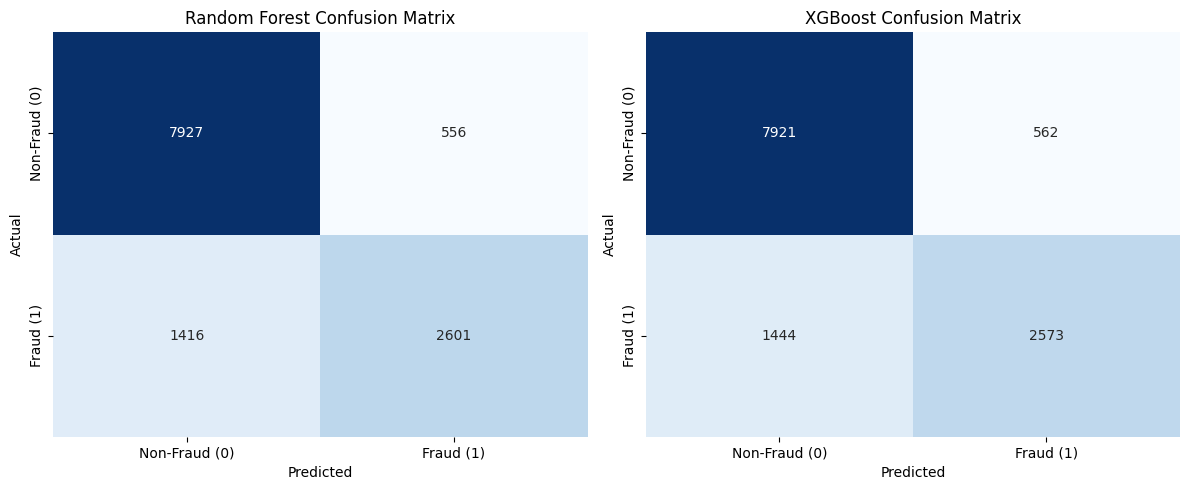

[[[7927, 556], [1416, 2601]], [[7921, 562], [1444, 2573]]]


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Confusion matrices
cm_rf = [[7927, 556],   # Random Forest
         [1416, 2601]]

cm_xgb = [[7921, 562],  # XGBoost (approx based on recall 0.64)
          [1444, 2573]]

models = ['Random Forest', 'XGBoost']
cms = [cm_rf, cm_xgb]

plt.figure(figsize=(12, 5))

for i, cm in enumerate(cms):
    plt.subplot(1, 2, i+1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'{models[i]} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])

plt.tight_layout()
plt.show()


print(cms)